In [6]:
import pandas as pd
from collections import Counter

In [7]:
#DATA PRECPROCESSING-----------------------------------------------------------------------------------------------

# File paths
users_file = 'Users.csv'
books_file = 'Books.csv'
ratings_file = 'Ratings.csv'

# Load the datasets
users_df = pd.read_csv(users_file)
books_df = pd.read_csv(books_file)
ratings_df = pd.read_csv(ratings_file)

# Users Data Preprocessing
# Handle missing values in 'Age' and 'Location'
users_df['Age'].fillna(users_df['Age'].median(), inplace=True)
users_df['Location'].fillna('Unknown', inplace=True)


# Books Data Preprocessing
# Convert 'Year-Of-Publication' to numeric and handle non-numeric values
books_df['Year-Of-Publication'] = pd.to_numeric(books_df['Year-Of-Publication'], errors='coerce')
books_df['Year-Of-Publication'].fillna(books_df['Year-Of-Publication'].median(), inplace=True)
# Handle missing values in 'Book-Author' and 'Publisher'
books_df['Book-Author'].fillna('Unknown', inplace=True)
books_df['Publisher'].fillna('Unknown', inplace=True)

# Drop the url columns as we will not be using them
books_df.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)

# Ratings Data Preprocessing
# Merge 'Ratings' with 'Books' to filter out books not in the 'Books' dataset
ratings_df = ratings_df[ratings_df['ISBN'].isin(books_df['ISBN'])]

# Merge books_df, users_df, and ratings_df
merged_df = pd.merge(ratings_df, books_df, on='ISBN', how='inner')
merged_df = pd.merge(merged_df, users_df, on='User-ID', how='inner')

# Filter ratings above 2
#merged_df = merged_df[merged_df['Book-Rating'] > 2]

# Filter users aged less than 110
merged_df = merged_df[merged_df['Age'] < 110]

# Count the number of ratings by each user
user_ratings_count = merged_df['User-ID'].value_counts()

# Keep only users who have rated 3 or more books
valid_users = user_ratings_count[user_ratings_count >= 2].index
merged_df = merged_df[merged_df['User-ID'].isin(valid_users)]

# Use only a fraction of the dataset
merged_df = merged_df.sample(frac=0.1, random_state=42)

# Data Splitting
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(merged_df, test_size=0.7, random_state=42)

# Checking the transformations and missing values after preprocessing
print("\nData after preprocessing:")
print("Unique values in 'Year-Of-Publication':", books_df['Year-Of-Publication'].unique())
print("\nMissing values after preprocessing:")
print("Users:", users_df.isnull().sum())
print("Books:", books_df.isnull().sum())
print("Ratings:", ratings_df.isnull().sum())



/var/folders/tz/f5wwvbqj0sjgxsr35rx5h1k00000gs/T/ipykernel_12017/2508546102.py:10: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df = pd.read_csv(books_file)



Data after preprocessing:
Unique values in 'Year-Of-Publication': [2002. 2001. 1991. 1999. 2000. 1993. 1996. 1988. 2004. 1998. 1994. 2003.
 1997. 1983. 1979. 1995. 1982. 1985. 1992. 1986. 1978. 1980. 1952. 1987.
 1990. 1981. 1989. 1984.    0. 1968. 1961. 1958. 1974. 1976. 1971. 1977.
 1975. 1965. 1941. 1970. 1962. 1973. 1972. 1960. 1966. 1920. 1956. 1959.
 1953. 1951. 1942. 1963. 1964. 1969. 1954. 1950. 1967. 2005. 1957. 1940.
 1937. 1955. 1946. 1936. 1930. 2011. 1925. 1948. 1943. 1947. 1945. 1923.
 2020. 1939. 1926. 1938. 2030. 1911. 1904. 1949. 1932. 1928. 1929. 1927.
 1931. 1914. 2050. 1934. 1910. 1933. 1902. 1924. 1921. 1900. 2038. 2026.
 1944. 1917. 1901. 2010. 1908. 1906. 1935. 1806. 2021. 2012. 2006. 1909.
 2008. 1378. 1919. 1922. 1897. 2024. 1376. 2037.]

Missing values after preprocessing:
Users: User-ID     0
Location    0
Age         0
dtype: int64
Books: ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher           

# **Content Based Filtering**

### 1. Weighted rating scores of each book for prediction

### NOTE: May not need

In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import linear_kernel

# Function that computes the weighted rating of each book
# We are utilizing the IMDB formula for weighted average ratings
def weighted_rating(dataframe, m, C):
    v = dataframe['Rating_Count']
    R = dataframe['Average_Rating']
    return (v / (v + m) * R) + (m / (m + v) * C)

# Count the amount of ratings
book_rated_count = ratings_df['ISBN'].value_counts().reset_index()
book_rated_count.columns = ['ISBN', 'Rating_Count']

# print(book_rated_count)

# Calculate the average of the ratings for each book
average_ratings = merged_df.groupby('ISBN')['Book-Rating'].mean().reset_index()
average_ratings.columns = ['ISBN', 'Average_Rating']
sorted_ratings = average_ratings.sort_values(by='Average_Rating', ascending=False)

# Merge the book count and average ratings
merged_data = pd.merge(book_rated_count, average_ratings, on='ISBN', how='inner')

# Calculate mean of 'Average_Rating' column
C = average_ratings['Average_Rating'].mean()
print("Mean Average Rating:", C)

# Calculate the minimum number of ratings required to be in the chart, m
m = book_rated_count['Rating_Count'].quantile(0.80)
print("Minimum ratings required:", m)

# Filter out all qualified books into a new DataFrame
q_books = merged_data.copy().loc[book_rated_count['Rating_Count'] >= m]

# Apply weighted rating function to calculate the weighted rating for each book
q_books['Weighted_Rating'] = q_books.apply(weighted_rating, axis=1, m=m, C=C)

# Sorting the DataFrame by 'Weighted_Rating' in descending order
sorted_q_books = q_books.sort_values(by='Weighted_Rating', ascending=False)

# Print the result
print(sorted_q_books)


Mean Average Rating: 7.699436189271788
Minimum ratings required: 3.0
           ISBN  Rating_Count  Average_Rating  Weighted_Rating
36   044022165X           386            10.0         9.982258
40   0060502258           376            10.0         9.981790
56   043935806X           334            10.0         9.979520
59   0060938455           321            10.0         9.978698
69   0061009059           291            10.0         9.976525
..          ...           ...             ...              ...
370  0425142485            90             3.0         3.151595
308  0688177859           108             3.0         3.127012
223  0451202341           145             3.0         3.095259
222  0786885688           145             3.0         3.095259
196  031242227X           161             3.0         3.085965

[3163 rows x 4 columns]


### 2. Content Based Recommendation using book title and author
We will use content based filtering to create part of our recommendation system. We will use book information for this part. The book information includes: Book title and author

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

# Create content dataframe with only the book title and author
content_df = merged_df[['Book-Title', 'Book-Author']].copy()

# Combine the title and author and store in Book-Information column
content_df['Book-Information'] = content_df['Book-Title'] + ' ' + content_df['Book-Author']

# Drop all duplicate rows based on the 'Book-Information' column
content_df = content_df.drop_duplicates(subset='Book-Information')

# Reset the index after dropping duplicates
content_df = content_df.reset_index(drop=True)

# Construct the required TF-IDF matrix for all books information
books_tfidf_matrix = tfidf.fit_transform(content_df['Book-Information'])

# Calculate cosine similarity of the books matrix
similarity = linear_kernel(books_tfidf_matrix, books_tfidf_matrix)

def content_based_recommendations(book_title, book_author, similarity_matrix, df, top_n):
    # Combine title and author for the given book
    input_book_info = book_title + ' ' + book_author

    # Get the index of the input book
    input_book_index = df[df['Book-Information'] == input_book_info].index[0]

    # Get the cosine similarity using the precomputed similarity matrix
    similarity_scores = similarity_matrix[input_book_index]

    # Get the indices of the top-n most similar books
    top_indices = similarity_scores.argsort()[-top_n-1:-1]

    # Return the top-n most similar books
    return df.loc[top_indices, 'Book-Title']


In [8]:
NUM_OF_RECOMMENDED_BOOKS = 5

# Use the random_state in the sample method
random_row = train_data.sample(n=1)

# Use recommend system to get a content based recommendation of the top 5 books for the user
book_title = random_row['Book-Title'].values[0]
book_author = random_row['Book-Author'].values[0]\

recommendations_existing_user = content_based_recommendations(book_title, book_author, similarity, content_df, NUM_OF_RECOMMENDED_BOOKS)

print(f"Recommendations for '{book_title}' by {book_author} (Existing User):")
print(recommendations_existing_user)


Recommendations for 'When Love Awaits' by Johanna Lindsey (Existing User):
11027                          Once a Princess
13362           A Man to Call My Own : A Novel
16991                        Surrender My Love
18577    A Loving Scoundrel (Lindsey, Johanna)
10783                          A Pirate's Love
Name: Book-Title, dtype: object


# **Collaborative Filtering**

In [4]:


ratings = pd.DataFrame(train_data.groupby('ISBN')['Book-Rating'].mean())

ratings['num_ratings'] = pd.DataFrame(train_data.groupby('ISBN')['Book-Rating'].count())
ratings.head()

bookmat = train_data.pivot_table(index='User-ID', columns='ISBN', values='Book-Rating')
bookmat.head()

ratings.sort_values('num_ratings', ascending=False).head(10)

,Book-Rating,num_ratings
ISBN,,
0971880107,0.611111,54
0316666343,4.421053,38
0385504209,4.346154,26
044023722X,1.720000,25
0316601950,3.041667,24
0452282152,4.227273,22
0060928336,4.833333,18
059035342X,5.500000,18
0786868716,4.611111,18


Best Parameters:  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 50}
Best RMSE:  3.782717606069811
Test RMSE:  3.832613773718362


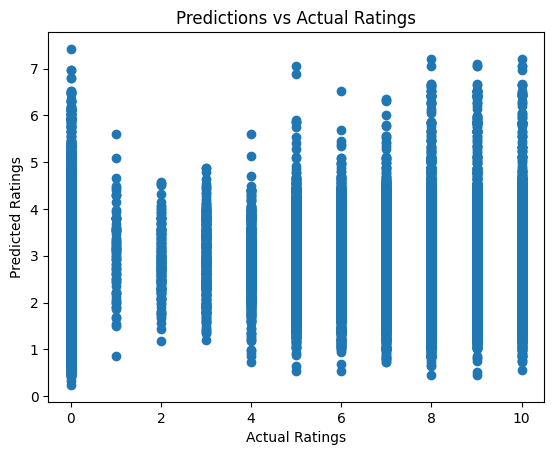

In [13]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Create a LabelEncoder object
isbn_encoder = LabelEncoder()

# Fit the encoder to the ISBN column
train_data['ISBN_encoded'] = isbn_encoder.fit_transform(train_data['ISBN'])
test_data['ISBN_encoded'] = isbn_encoder.fit_transform(test_data['ISBN'])

# Convert the ISBN column to a numpy array
x_train = train_data[['User-ID', 'ISBN_encoded']].to_numpy()
x_test = test_data[['User-ID', 'ISBN_encoded']].to_numpy()

# Specify parameter grid for KNN
param_grid = {
    'n_neighbors': [40, 45, 50],
    'algorithm': ['auto'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
}

# Create KNN model
knn_model = KNeighborsRegressor()

# Use GridSearchCV to find the best parameters
gs = GridSearchCV(knn_model, param_grid, scoring='neg_mean_squared_error', cv=3)
gs.fit(x_train, train_data['Book-Rating'])

# Print the best parameters and corresponding RMSE
print("Best Parameters: ", gs.best_params_)
print("Best RMSE: ", (-gs.best_score_) ** 0.5)

# Predict on the test set
test_predictions = gs.predict(x_test)

# Evaluate the model
test_rmse = mean_squared_error(test_data['Book-Rating'], test_predictions) ** 0.5
print("Test RMSE: ", test_rmse)

# Plot predictions vs. actual ratings
plt.scatter(test_data['Book-Rating'], test_predictions)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predictions vs Actual Ratings')
plt.show()

In [14]:
def collaborative_recommendations(model, user_id, book_isbn, isbn_encoder):
    # Encode the ISBN for the given book
    book_encoded = isbn_encoder.transform([book_isbn])[0]

    # Predict the rating for the given user and book
    prediction = model.predict([[user_id, book_encoded]])[0]

    return prediction

In [16]:
user_id = 143964
book_isbn = '0688149790'

predicted_rating = collaborative_recommendations(gs, user_id, book_isbn, isbn_encoder)

print(f"Predicted rating for user {user_id} and book {book_isbn}: {predicted_rating}")

Predicted rating for user 143964 and book 0688149790: 3.04


# OTHER (DELETE BEFORE SUBMIT)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Create a user-item matrix
user_item_matrix = pd.pivot_table(content_df, values='Book-Rating', index='User-ID', columns='ISBN', fill_value=0)

print(content_df)
print(user_item_matrix)
# Calculate user-user cosine similarity
user_similarity = cosine_similarity(user_item_matrix)

# Function to get top N recommendations for a user using collaborative filtering
def collaborative_filtering_recommendations(user_id, user_item_matrix, user_similarity, N=5):
    # Get the target user's ratings
    target_user_ratings = user_item_matrix.loc[user_id].values.reshape(1, -1)

    # Calculate similarity scores between the target user and all other users
    sim_scores = cosine_similarity(target_user_ratings, user_item_matrix.values)


    # Get the indices of users with highest similarity scores
    similar_users = np.argsort(sim_scores[0])[::-1][1:N+1]

    print(similar_users)
    # Get books that the target user hasn't rated
    unrated_books = user_item_matrix.columns[user_item_matrix.loc[user_id] == 0]
    print(unrated_books)

    # Convert unrated_books to a list
    unrated_books = unrated_books.tolist()

    print("user_item_matrix shape:", user_item_matrix)

    # Get the average rating of each unrated book from similar users
    average_ratings = np.mean(user_item_matrix.loc[similar_users, unrated_books], axis=0)

    # Get top N recommendations
    top_n_books = unrated_books[np.argsort(average_ratings)[::-1][:N]]

    return top_n_books

# Example usage
target_user_id = 14559  # Replace with the actual user ID
top_recommendations = collaborative_filtering_recommendations(target_user_id, user_item_matrix, user_similarity, N=5)

# Display the top N recommended books
recommended_books_info = books_df[books_df['ISBN'].isin(top_recommendations)]
print("Top N Recommended Books:")
print(recommended_books_info[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication']])


ISBN     0007154607  0020209851  0020518609  0020795904  006000438X  \
User-ID                                                               
2276              0           0           0           0           0   
6242              0           0           0           0           0   
8067              0           0           0           0           0   
11676             0           0           0           0           0   
12100             0           0           0           0           0   

ISBN     0060006293  0060086386  0060089539  0060109955  0060159383  ...  \
User-ID                                                              ...   
2276              0           0           0           0           0  ...   
6242              0           0           0           0           0  ...   
8067              0           0           0           0           0  ...   
11676             0           0           0           0           9  ...   
12100             0           0           0   

KeyError: ignored

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import normalize

# Collaborative Filtering based on users' age
# def collaborative_filtering(user_age, train_data, users_df):
#     # Filter users based on age
#     filtered_users = users_df[users_df['Age'] == user_age]

#     # Filter training data based on selected users and non-zero ratings
#     filtered_train_data = train_data[(train_data['User-ID'].isin(filtered_users['User-ID'])) & (train_data['Book-Rating'] != 0)]

#     # Create a user-item matrix for collaborative filtering
#     user_item_matrix = filtered_train_data.pivot_table(index='User-ID', columns='ISBN', values='Book-Rating')
#     user_item_matrix = user_item_matrix.fillna(0)

#     print(user_item_matrix)
#     # Calculate cosine similarity between users
#     cosine_sim_users = cosine_similarity(user_item_matrix, user_item_matrix)

#     return cosine_sim_users

# Content-Based Filtering based on book ratings
# def content_based_filtering(train_data, books_df):
#     # Get the top N books with the highest average ratings
#     # top_books = train_data.groupby('ISBN')['Book-Rating'].mean().reset_index()
#     # top_books = top_books.sort_values(by='Book-Rating', ascending=False)

#     # print(top_books)
#     # # Merge with books_df to get additional book information
#     # top_books = pd.merge(top_books, books_df, on='ISBN')

#     # Create a TF-IDF vectorizer for book titles
#     tfidf_vectorizer = TfidfVectorizer(stop_words='english')
#     tfidf_matrix = tfidf_vectorizer.fit_transform(train_data['Book-Rating'])

#     print(tfidf_matrix)

#     # # Apply Truncated SVD for dimensionality reduction
#     # svd = TruncatedSVD(n_components=100)
#     # tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)

#     # # Calculate the cosine similarity between book titles
#     # cosine_sim_books = cosine_similarity(tfidf_matrix_reduced, tfidf_matrix_reduced)
#     # print(cosine_sim_books)
#     # return cosine_sim_books


# def jaccard_similarity(content_matrix):
#     # Convert the sparse matrix to a dense matrix
#     dense_content_matrix = content_matrix.toarray()

#     # Compute Jaccard similarity using pairwise_distances with metric='jaccard'
#     jaccard_sim = 1 - pairwise_distances(dense_content_matrix, metric='jaccard')
#     return normalize(jaccard_sim, axis=1, norm='l1')  # Normalize the similarity scores

# def content_based_filtering(content_df):
#     # Sort by ratings and select the top 10,000 rows
#     print(content_df)
#     books_df = content_df[['Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Book-Rating']]

#     # Puts all features in a string
#     books_df['Content'] = books_df.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)

#     print('--------')
#     print(books_df)

#     tfidf_vectorizer = TfidfVectorizer()
#     content_matrix = tfidf_vectorizer.fit_transform(books_df['Content'])

#     content_similarity = cosine_similarity(content_matrix, content_matrix)

#     return books_df, content_similarity, tfidf_vectorizer

# # Example usage
# books_df = pd.read_csv('Books.csv')  # Load books data
# content_df, content_similarity, tfidf_vectorizer = content_based_filtering(books_df, top_n=10000)


# # Hybrid Recommender System
# def hybrid_recommender(user_age, user_id, train_data, books_df, users_df):
#     # Collaborative Filtering
#     # collaborative_results = collaborative_filtering(user_age, train_data, users_df)

#     # Content-Based Filtering
#     content_based_results = content_based_filtering(train_data)
#     # # Combine the results using a weighted sum
#     # # Note: Here, we use the mean rating from collaborative filtering
#     # # and the cosine similarity values from content-based filtering
#     # collaborative_results_df = pd.DataFrame(collaborative_results)
#     # collaborative_results_df = collaborative_results_df.fillna(0)

#     # hybrid_results = pd.DataFrame(index=train_data['User-ID'], columns=train_data['ISBN'])
#     # hybrid_results['Hybrid-Score'] = (0.5 * collaborative_results_df.values +
#     #                                    0.5 * content_based_results.loc[collaborative_results_df.index, collaborative_results_df.columns].fillna(0))

#     # # Sort the results by Hybrid-Score in descending order
#     # recommended_books = hybrid_results.unstack().reset_index(name='Hybrid-Score')
#     # user_rated_books = train_data[train_data['User-ID'] == user_id]['ISBN']
#     # recommended_books = recommended_books[~recommended_books['ISBN'].isin(user_rated_books)]

#     # return recommended_books[['ISBN', 'Hybrid-Score']].nlargest(5, 'Hybrid-Score')
#     return

def content_based_recommendations(books_df, ratings_df, user_id, threshold=5, top_n=10):
    # Filter ratings data for the user and ratings above the threshold
    user_ratings = ratings_df[(ratings_df['User-ID'] == user_id)]

    # Get the ISBNs of positively rated books by the user
    positively_rated_isbns = user_ratings['ISBN'].unique()

    # Filter content data for positively rated books
    positively_rated_books_df = books_df[books_df['ISBN'].isin(positively_rated_isbns)].drop('ISBN', axis=1)

    # Drop ISBN from books as we will not use that to compare
    all_books = books_df.drop('ISBN', axis=1)

    # Create the 'Content' column without including the 'ISBN'; this will create a string of all the info about that book
    positively_rated_books_df['Content'] = positively_rated_books_df.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)
    all_books['Content'] = all_books.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)

    # Apply content-based filtering to recommend similar books
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    content_tfidf_matrix = tfidf_vectorizer.fit_transform(positively_rated_books_df['Content'])
    books_tfidf_matrix = tfidf_vectorizer.fit_transform(all_books['Content'])

    # Get the similarity between all books and the books that user recommended
    content_similarity = cosine_similarity(content_tfidf_matrix, books_tfidf_matrix)

    print(content_similarity)

    # Identify books similar to the positively rated ones
    similar_books_indices = content_similarity.argsort(axis=1)[:, ::-1][:, :top_n]
    similar_books_info = positively_rated_books_df.iloc[similar_books_indices.flatten()]

    return similar_books_info

# Example usage
user_id = 276729  # Replace with the actual user ID
threshold = 5  # Ratings above this threshold will be considered
top_n = 10  # Number of recommendations to return

recommended_books = content_based_recommendations(books_df, ratings_df, user_id, threshold, top_n)
print("Content-Based Recommendations:", recommended_books)


ValueError: ignored